In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle

In [25]:
%matplotlib inline
TIME_STEP = 9
IMG_SIZE = 32
TIME_WND = 7*3 #IN DAYS


In [3]:
dataset = pd.read_csv('data_earthquake_2000-2017.csv',encoding='latin1', sep=';')
dataset.head()

,Año,Mes,Día,Hora,Minuto,Segundo,Fecha,Latitud,Longitud,Prof.,Magn,Date,Horario,Dtime,time,diff
0,2000,1,2,3,42,12.7,36527,-33.410,-70.880,81.9,2.5,36527,0.154314,36527.15431,1.154314,0.000000
1,2000,1,2,5,3,13.1,36527,-33.787,-71.339,45.8,3.7,36527,0.210568,36527.21057,1.210568,0.056255
2,2000,1,2,18,55,55.0,36527,-31.535,-71.318,35.7,3.8,36527,0.788831,36527.78883,1.788831,0.578263
3,2000,1,2,19,36,25.8,36527,-32.446,-70.923,95.2,2.7,36527,0.816965,36527.81697,1.816965,0.028134
4,2000,1,3,2,41,41.7,36528,-32.986,-71.348,41.8,3.6,36528,0.112288,36528.11229,2.112288,0.295323


In [4]:
print(dataset.shape)
dataset = dataset[dataset['Prof.'] >= 60.0 ]
print(dataset.shape)

(85636, 16)
(37195, 16)


In [7]:
zone1 = dataset[dataset['Latitud'] > -23]
zone2 = dataset[(dataset.Latitud < -23) & (dataset.Latitud > -34)] 
zone3 = dataset[dataset['Latitud'] < -34]
print(dataset.shape)
print(zone1.shape)


(37195, 16)
(16389, 16)


In [8]:
def scale(data):
    old_max = data['Magn'].max()
    old_min = data['Magn'].min()
    old_range =  old_max - old_min
    new_range = 255 - 10 
    return data['Magn'].apply(lambda v: int(((v-old_min)*new_range)/old_range)-10)
    
zone3['Magn']= scale(zone3)

/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
def build_time_series(data,y_col=0):
    timestep = (TIME_STEP*TIME_WND)
    dim_0 = data.shape[0]- timestep
    first = data.Date[:1].values[0]
    y = []
    series = []
    for i in range(dim_0):
        series_df = data[(data.Date >= first+i) & (data.Date < first+i+timestep)]
        y_df = data[data.Date == first+i+timestep]
        series.append(series_df)
        y.append(y_df)

    return series,y,first

series,y,first = build_time_series(zone3,TIME_STEP)
series[0]

,Año,Mes,Día,Hora,Minuto,Segundo,Fecha,Latitud,Longitud,Prof.,Magn,Date,Horario,Dtime,time,diff
19,2000,1,5,20,57,16.9,36530,-34.616,-71.139,66.5,52,36530,0.873112,36530.87311,4.873112,0.168722
21,2000,1,6,1,48,8.7,36531,-34.643,-70.740,102.1,83,36531,0.075101,36531.07510,5.075101,0.181978
27,2000,1,7,2,51,2.2,36532,-34.863,-71.068,102.1,36,36532,0.118775,36532.11878,6.118775,0.043134
63,2000,1,14,19,7,51.3,36539,-35.450,-71.217,139.8,62,36539,0.797122,36539.79712,13.797122,0.420911
73,2000,1,17,11,55,45.8,36542,-35.147,-71.201,97.2,78,36542,0.497058,36542.49706,16.497058,0.458362
87,2000,1,23,3,14,46.7,36548,-36.667,-73.606,60.8,99,36548,0.135263,36548.13526,22.135263,0.211802
94,2000,1,25,23,42,33.5,36550,-34.218,-71.137,68.2,47,36550,0.987888,36550.98789,24.987888,0.240043
104,2000,1,29,5,34,24.6,36554,-34.080,-70.905,74.9,21,36554,0.232229,36554.23223,28.232229,0.111532
106,2000,1,29,22,52,37.1,36554,-34.780,-70.907,87.6,47,36554,0.953207,36554.95321,28.953207,0.024896
115,2000,1,31,13,44,19.9,36556,-37.579,-72.235,103.0,115,36556,0.572453,36556.57245,30.572453,0.296919


In [29]:
def create_matrix(data,current_date):
    max_lat = data['Latitud'].max()
    min_lat = data['Latitud'].min()
    max_lon = data['Longitud'].max()
    min_lon = data['Longitud'].min()
    n_rows = n_columns = IMG_SIZE
    matrix = np.zeros(shape=(n_rows,n_columns),dtype=int)
    n_sum_lat = (max_lat-min_lat)/n_columns
    n_sum_lon = (max_lon-min_lon)/n_rows
    
    X = []
    for k in range (TIME_STEP):
        #dayk = data.loc[(data['Date'] == current_date+k)]
        dayk = data.loc[(data.Date >= current_date+k) & (data.Date < first+k+TIME_WND)]
        start_lon = min_lon
        end_lon = min_lon + n_sum_lon
        for i in range (n_rows):
            start_lat = min_lat
            end_lat = min_lat + n_sum_lat
            for j in range (n_columns):
                x = dayk.loc[(dayk['Latitud'] >= start_lat) & (dayk['Latitud'] <= end_lat) & (dayk['Longitud'] >= start_lon) & (dayk['Longitud'] <= end_lon)]
                #print(x.Magn.values,end = '')
                matrix[i][j] = x['Magn'].max() if (len(x['Magn'].values) != 0) else 0
                #print(matrix[i][j],end = '')
                start_lat = end_lat
                end_lat = end_lat + n_sum_lat
            #print('')
            start_lon = end_lon
            end_lon = end_lon + n_sum_lon
        #print('*****************************************************************')
        #X.append(matrix.flatten())
        img = Image.fromarray(matrix.astype('uint8'),'L')
        X.append(img)
    return X

In [30]:
X = []
for num, serie in enumerate(series):
    X.append(create_matrix(serie,first+num))
pickle_X_out = open("X.pickle","wb")
pickle.dump(X,pickle_X_out)
pickle_X_out.close()


In [28]:
aux = [ create_matrix(series[0],first)] 

000000000000000000099000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
00000000000000000000000000000000
000000000000000000000000620780052470
000000000000000000000000000360000
00000000000000000000000000000000
00000000000000000000000000000000
000000000000000000000000000083000
00000000000000000000000000000000
000

In [15]:
def create_images_input(X,mode='h'):
    
    if mode == 'h':
        for it, images in enumerate(X):
        
            widths, heights = zip(*(i.size for i in images))
            total_width = sum(widths)
            max_height = max(heights)
        
            new_im = Image.new('L', (total_width, max_height))
        
            x_offset = 0
            #print(len(images))
        
            for im in images:
                plt.imshow(np.asarray(im))
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0]
   
            #imshow(np.asarray(new_im))
            new_im.save("images/quake3-{0}.jpg".format(it), "JPEG", quality=80, optimize=True, progressive=True)
    if mode == 'grid':
        for it, images in enumerate(X):
            new_im = Image.new('L', (256,256))
            for im in images:
                for i in range(0,256):
                    for j in range(0,256):
                        new_im.paste(im, (i,j))
        plt.imshow(np.asarray(new_im))

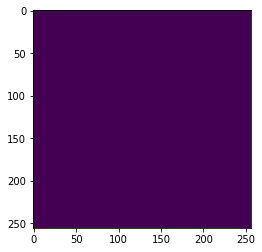

In [16]:
create_images_input(aux,'grid')